## Hypothesis Testing
#### Important: Make sure you have the following dataframe in the ram before executing the codes
##### (1) df_10ksp_filtered3 for the approach of BAG OF WORDS
##### (2) df_10ksp_filtered4 for the approach of TF-IDF
##### (3) df_10ksp_filtered5 for the approach of BERT

In [1]:
%store -r df_10ksp_filtered3
%store -r df_10ksp_filtered4
%store -r df_10ksp_filtered5

In [4]:
import pandas as pd
import numpy as np

In [17]:
# in case you need to call these variables by uploading:
# skip this if you already created these variables in jupyter notebook
# df_10ksp_filtered3=pd.read_csv('filter3.csv')#if your local save is under other file name, please change
# df_10ksp_filtered4=pd.read_csv('filtered4.csv')
# df_10ksp_filtered5=pd.read_csv('finbert_df5.csv')

## 1. BAG OF WORDS

In [6]:
df_10ksp_filtered3['neg_proportion']=df_10ksp_filtered3['Negative']/df_10ksp_filtered3['Total Word Count']

In [7]:
df_10ksp_filtered3

,Unnamed: 0,level_0,index,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,...,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Item 7 Word Count,Item 7A Word Count,Total Word Count,neg_proportion
0,1,7,72,0000004904-00-000039,10-K405,19991231,20000324,Not found,AMERICAN ELECTRIC POWER COMPANY INC,4904,...,0,1,14,0,0,14,334,286,620,0.004839
1,7,60,664,0000037996-00-000019,10-K,19991231,20000316,Not found,FORD MOTOR CO,37996,...,47,81,10,12,11,10,4996,871,5867,0.009034
2,9,83,925,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,52988,...,6,20,38,3,5,5,2205,11,2216,0.004964
3,10,89,1031,0000060086-00-000011,10-K405,19991231,20000330,Not found,LOEWS CORP,60086,...,125,344,759,33,76,67,23753,1507,25260,0.028820
4,12,107,1271,0000912057-00-014257,10-K405,19991231,20000329,Not found,NORTHERN STATES POWER CO /MN/,72903,...,49,138,103,31,44,62,10158,20,10178,0.008744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,5017,11006,253743,0000950170-23-005559,10-K,20221231,20230301,20230301,Ceridian HCM Holding Inc.,1725057,...,55,92,38,18,19,48,9980,1036,11016,0.005719
3330,5018,11009,253806,0000950170-23-064855,10-K,20230930,20231117,20231117,WestRock Co,1732845,...,41,172,59,18,58,91,7773,2116,9889,0.009910
3331,5019,11010,253854,0001739940-23-000008,10-K,20221231,20230223,20230223,Cigna Group,1739940,...,116,304,196,35,134,108,18734,31,18765,0.016573
3332,5020,11013,253910,0001748790-23-000030,10-K,20230630,20230817,20230817,Amcor plc,1748790,...,39,129,45,13,36,69,8192,920,9112,0.015255


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


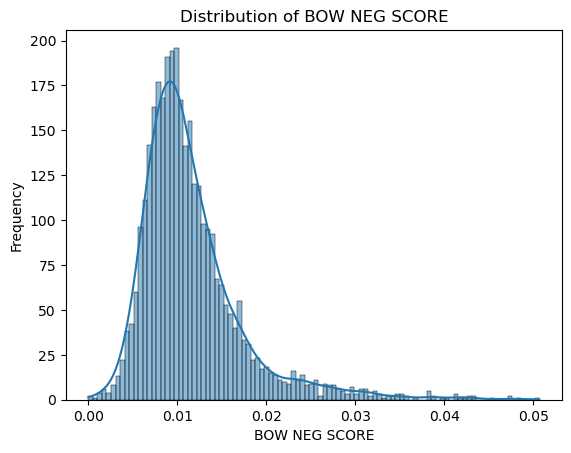

In [8]:
# The distribution of BOW Negative Scores
df_10ksp_filtered3.head(3)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_10ksp_filtered3, x='neg_proportion', bins=100, kde=True)
plt.title('Distribution of BOW NEG SCORE')
plt.xlabel('BOW NEG SCORE')
plt.ylabel('Frequency')
plt.show()

## 2. TF-IDF

In [19]:
df_10ksp_filtered4 = df_10ksp_filtered4.iloc[:, :-7]
df_10ksp_filtered4 = df_10ksp_filtered4.iloc[:, 1:]

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


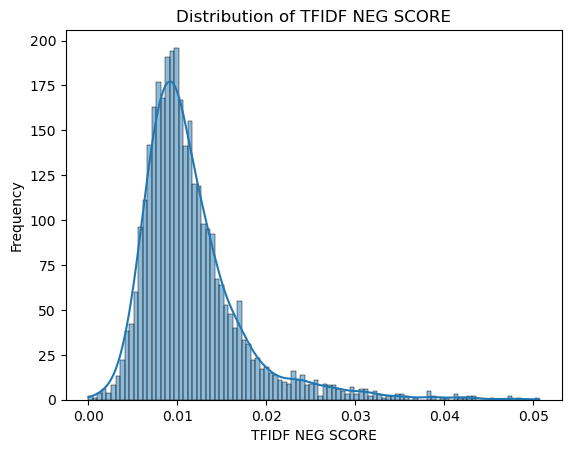

In [21]:
# The distribution of TF-IDF negative scores
sns.histplot(data=df_10ksp_filtered3, x='neg_proportion', bins=100, kde=True)
plt.title('Distribution of TFIDF NEG SCORE')
plt.xlabel('TFIDF NEG SCORE')
plt.ylabel('Frequency')
plt.show()

## 3. FINBERT

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


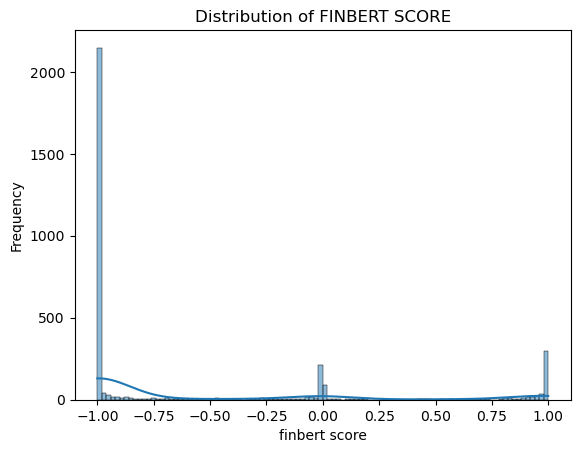

In [22]:
# The distribution of FINBERT  scores
sns.histplot(data=df_10ksp_filtered5, x='FINBERT SCORE', bins=100, kde=True)
plt.title('Distribution of FINBERT SCORE')
plt.xlabel('finbert score')
plt.ylabel('Frequency')
plt.show()

### Preparation of the Makret responce data (abnormal return and volume)and financial report data (revenue and profit)

#### The data must be mapped at the dimension of Accession number

In [23]:
#Prepare the dim table
target_dim=df_10ksp_filtered3.iloc[:,0:8]
target_dim.reset_index(inplace=True,drop=True)



In [40]:
target_dim.to_csv('target_dim.csv')